In [34]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter('ignore')

start_day = datetime(2025, 2, 1)
mid_day = datetime(2025, 3, 1)
end_day = datetime(2025, 4, 1)

# Read auth_df that has the datetime value over report period
# Read user_df that has all values
# Read consult_df that has all values
# Read daily_access_log table that has the datetime value over report period
# 카카오톡스토어 파마브로스 매출 데이터(최근 1년) 테이블 읽기 = kakao_df1
# 카카오톡스토어 스타팜 매출 데이터(최근 1년) 테이블 읽기 = kakao_df2
# 친한스토어 매출 데이터(전체) 테이블 읽기 = fs_df

auth_df = pd.read_csv('/Users/seanyu_mac/Downloads/auth_info_after_20250101-2025-04-02_112150.csv')
user_df = pd.read_csv('/Users/seanyu_mac/Downloads/public_pb_user_export_2025-04-02_132624.csv')
consult_df = pd.read_csv('/Users/seanyu_mac/Downloads/public_consulting_export_2025-04-02_132648.csv')
log_df = pd.read_csv('/Users/seanyu_mac/Downloads/query_2-2025-04-02_12746.csv')
kakao_df1 = pd.read_excel('/Users/seanyu_mac/Downloads/20250402133555.xlsx')
kakao_df2 = pd.read_excel('/Users/seanyu_mac/Downloads/20250402133738.xlsx')
fs_df = pd.read_excel('/Users/seanyu_mac/Downloads/주문내역_2024-04-02~2025-04-02.xlsx')

pre_year = start_day.strftime('%Y')
post_year = mid_day.strftime('%Y')
pre_month = start_day.strftime('%m')
post_month = mid_day.strftime('%m')

# rate 함수 정의
def rate(before, after):
    percent = (after - before) / before * 100
    percent = np.round(percent, 1)
    if percent > 0:
        result = f'{percent}% 증가'
        return result
    else:
        result = f'{percent}% 감소'
        return result

# Left join user_df and auth_df so as to get pre_sign_up_num & post_sign_up_num
merged_df = user_df.merge(auth_df, left_on='id', right_on='user_id', how='inner')
merged_df['reg_dt'] = pd.to_datetime(merged_df['reg_dt'], format='mixed')
con1 = (merged_df['reg_dt'] >= start_day) & (merged_df['reg_dt'] < mid_day)
con2 = (merged_df['reg_dt'] >= mid_day) & (merged_df['reg_dt'] < end_day)

pre_sign_up_num = merged_df[con1].index.size
post_sign_up_num = merged_df[con2].index.size
sign_up_percent = rate(post_sign_up_num, pre_sign_up_num)

# Get total_users_num till the end of last month
user_df['reg_dt'] = pd.to_datetime(user_df['reg_dt'], format='mixed')
con1 = user_df['reg_dt'] < end_day
total_users_num = user_df[con1].index.size

# Get total_consult_num till the end of last month
consult_df['reg_dt'] = pd.to_datetime(consult_df['reg_dt'], format='mixed')
con1 = consult_df['reg_dt'] < end_day
total_consult_num = consult_df[con1].index.size

# Get pre and post consult num in 2 months
pre_key = str(mid_day - timedelta(days=1))
post_key = str(end_day - timedelta(days=1))
pre_consult_num = consult_df.groupby(pd.Grouper(key='reg_dt', freq='M')).size()[pre_key]
post_consult_num = consult_df.groupby(pd.Grouper(key='reg_dt', freq='M')).size()[post_key]
percent_consult = rate(post_consult_num, pre_consult_num)

# Get pre and post MAU of pre_month_mau, post_month_mau
log_df['access_date'] = pd.to_datetime(log_df['access_date'], format='mixed')
log_df['created_at'] = pd.to_datetime(log_df['created_at'], format='mixed')
log_df.drop(log_df[log_df['user_id'].duplicated() == True].index, inplace=True)
con1 = log_df['access_date'] >= start_day
con2 = log_df['access_date'] < mid_day
pre_month_mau = log_df[con1 & con2].index.size
con1 = log_df['access_date'] >= mid_day
con2 = log_df['access_date'] < end_day
post_month_mau = log_df[con1 & con2].index.size
mau_rate = rate(post_month_mau, pre_month_mau)

# kakao_df 머지하여 생성하고 필요한 컬럼 정리
# 배송상태에서 특이값 제거
kakao_df = pd.concat([kakao_df1, kakao_df2])
remove_txts = ['204 결제 취소 완료',
               '208 환불 완료',
               '507 반품 결제 취소 완료',
               '303 결제 취소 완료',
               '404 교환 반송 중',
               '505 반품 반송 완료']

kakao_df.drop(kakao_df[kakao_df['주문상태'].isin(remove_txts)].index, inplace=True)

# 필요한 컬럼만 남기고 영문 컬럼명으로 재정의 : 'payment_id', 'order_id', 'product_name', 'option_name', 'quantity', 'sales'
kakao_df = kakao_df[['결제번호', '주문번호', '주문일', '주문상태', '상품명', '옵션', '수량', '정산기준금액']]
pre_col = ['결제번호', '주문번호', '주문일', '주문상태', '상품명', '옵션', '수량', '정산기준금액']
post_col = ['payment_id', 'order_id', 'order_date', 'status', 'product_name', 'option_name', 'quantity', 'sales']
col_dict = dict(zip(pre_col, post_col))
kakao_df.rename(columns=col_dict, inplace=True)

# order_date를 datetime 값으로 변환
kakao_df['order_date'] = pd.to_datetime(kakao_df['order_date'])

# fs_df 컬럼 정리하고 kakao_df 와 머지하여 sales_df 생성
con1 = fs_df['주문 상태'] == '배송완료'
con2 = fs_df['주문 상태'] == '배송중'
con3 = fs_df['주문 상태'] == '배송준비'
con4 = fs_df['주문 상태'] == '구매확정'
con5 = fs_df['주문 상태'] == '결제완료'
fs_df = fs_df[con1 | con2 | con3 | con4 | con5]

fs_df = fs_df[['결제 번호', '상품 번호', '결제 완료일', '주문 상태', '상품명', '옵션명', '수량', '정산가']]
col_dict = dict(zip(fs_df.columns.tolist(), kakao_df.columns.tolist()))
fs_df.rename(columns=col_dict, inplace=True)
sales_df = pd.concat([kakao_df, fs_df])

# 총 누적 판매 금액 = total_sales
# 일 평균 판매 금액 = daily_sales
# 주문당 평균 객단가 = arpu
# 지지난달 지난달 매출과 증감율 pre_sales, post_sales, sales_rate
total_sales = sales_df['sales'].sum()
sales_df['order_day'] = sales_df['order_date'].dt.date
daily_sales = np.round(total_sales / sales_df['order_day'].unique().size, 1)
arpu = np.round(total_sales / sales_df['order_id'].unique().size, 1)
con1 = sales_df['order_date'] >= start_day
con2 = sales_df['order_date'] < mid_day
pre_sales = sales_df.loc[con1 & con2, 'sales'].sum()
con1 = sales_df['order_date'] >= mid_day
con2 = sales_df['order_date'] < end_day
post_sales = sales_df.loc[con1 & con2, 'sales'].sum()
sales_rate = rate(pre_sales, post_sales)

def signup_graph():
    # x,y축 데이터 설정 (월,회원가입자수)
    months = []
    for i in user_df.groupby(pd.Grouper(key='reg_dt', freq='M')).size().keys():
        data = i.strftime('%Y-%m')
        months.append(data)
    
    months = months[-12:-1]
    
    signups = user_df.groupby(pd.Grouper(key='reg_dt', freq='M')).size().values
    signups = signups[-12:-1]
    
    # 그래프 크기 설정
    plt.figure(figsize=(10, 5))
    
    # 라인 그래프 그리기
    plt.plot(months, signups, marker='o', color='deepskyblue', linewidth=2, markersize=6, alpha=0.8)
    
    # 데이터 포인트에 숫자 표시
    for i, txt in enumerate(signups):
        plt.annotate(f"{txt:,}", (months[i], signups[i]), textcoords="offset points", xytext=(-5, 5),
                     ha='center', fontsize=10, color='deepskyblue')
    
    # 그래프 제목
    plt.title("Monthly Sign-up Users Counts (Number of People)", fontsize=14)
    
    # Y축 범위 및 눈금 설정
    plt.ylim(1000, 3000)
    plt.yticks([1000, 2000, 3000], ["1,000", "2,000", "3,000"])
    
    # X축 눈금 기울여 표시
    plt.xticks(rotation=30, ha="right")
    
    # 그리드 추가 (가독성 개선)
    plt.grid(axis='y', linestyle="--", alpha=0.5)
    
    # 위, 오른쪽 외곽선(테두리) 제거
    ax = plt.gca()  # 현재 축 가져오기
    ax.spines['top'].set_visible(False)    # 위 테두리 제거
    ax.spines['right'].set_visible(False)  # 오른쪽 테두리 제거
    
    # 그래프 출력
    plt.show()

def sales_graph():
    # x,y축 데이터 설정 (월,매출)
    months = []
    for i in sales_df.groupby(pd.Grouper(key='order_date', freq='M')).size().keys():
        data = i.strftime('%Y-%m')
        months.append(data)
    
    months = months[-12:-1]
    
    sales = sales_df.groupby(pd.Grouper(key='order_date', freq='M'))['sales'].sum().values
    sales = sales[-12:-1]
    
    # 그래프 크기 설정
    plt.figure(figsize=(10, 5))
    
    # 라인 그래프 그리기
    plt.plot(months, sales, marker='o', color='deepskyblue', linewidth=2, markersize=6, alpha=0.8)
    
    # 데이터 포인트에 숫자 표시
    for i, txt in enumerate(sales):
        plt.annotate(f"{txt:,}", (months[i], sales[i]), textcoords="offset points", xytext=(-5, 5),
                     ha='center', fontsize=10, color='deepskyblue')
    
    # 그래프 제목
    plt.title("Monthly Revenue (Korean Won)", fontsize=14)
    
    # Y축 범위 및 눈금 설정
    plt.ylim(10000000, 50000000)
    plt.yticks([10000000, 20000000, 30000000, 40000000, 50000000], ["10,000,000", "20,000,000", "30,000,000", '40,000,000', '50,000,000'])
    
    # X축 눈금 기울여 표시
    plt.xticks(rotation=30, ha="right")
    
    # 그리드 추가 (가독성 개선)
    plt.grid(axis='y', linestyle="--", alpha=0.5)
    
    # 위, 오른쪽 외곽선(테두리) 제거
    ax = plt.gca()  # 현재 축 가져오기
    ax.spines['top'].set_visible(False)    # 위 테두리 제거
    ax.spines['right'].set_visible(False)  # 오른쪽 테두리 제거
    
    # 그래프 출력
    plt.show()

In [35]:
print(f'1. 지지난달 {pre_year}년 {pre_month}월과 지난달 {post_year}년 {post_month}월을 비교')
print(f'2. {pre_month}월 기준 총 회원 가입 유저 수는 {total_users_num:,}명')
print(f'3. {pre_month}월 회원 가입자 수: {pre_sign_up_num:,}명 / {post_month}월 회원 가입자 수: {post_sign_up_num:,}명으로 전월 대비 {sign_up_percent}')
print(f'4. {post_month}월 기준, 총 누적 상담 건수는 {total_consult_num:,}건')
print(f'5. {pre_month}월 상담 수: {pre_consult_num:,}건, {post_month}월 상담 수: {post_consult_num:,}건으로 전월 대비 {percent_consult}')
print(f'6. {post_month}월 MAU {post_month_mau:,}명 (직전 {pre_month}월 {pre_month_mau:,}명 대비 {mau_rate})')

1. 지지난달 2025년 02월과 지난달 2025년 03월을 비교
2. 02월 기준 총 회원 가입 유저 수는 35,161명
3. 02월 회원 가입자 수: 1,954명 / 03월 회원 가입자 수: 3,302명으로 전월 대비 -40.8% 감소
4. 03월 기준, 총 누적 상담 건수는 42,406건
5. 02월 상담 수: 2,087건, 03월 상담 수: 2,231건으로 전월 대비 -6.5% 감소
6. 03월 MAU 1,297명 (직전 02월 1,325명 대비 2.2% 증가)


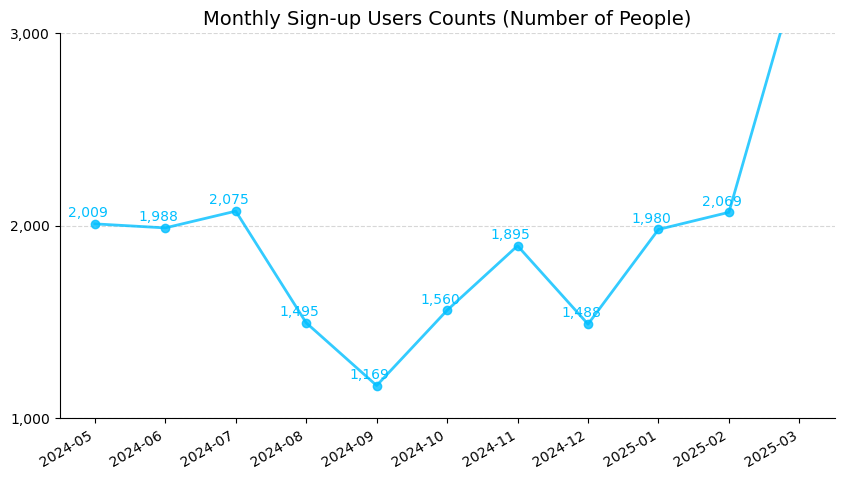

In [38]:
signup_graph()

In [40]:
print(f'1. 누적 판매금액 (최근 1년) : {total_sales:,}원')
print(f'2. 일 평균 판매액 : {daily_sales:,}원')
print(f'3. 객단가 : {arpu:,}원')
print(f'4. {pre_month}월 매출 : {pre_sales:,}원 / {post_month}월 매출 : {post_sales:,}원 ({sales_rate})')

1. 누적 판매금액 (최근 1년) : 5,164,563,900원
2. 일 평균 판매액 : 14,346,010.8원
3. 객단가 : 104,408.4원
4. 02월 매출 : 870,596,130원 / 03월 매출 : 1,075,110,760원 (23.5% 증가)


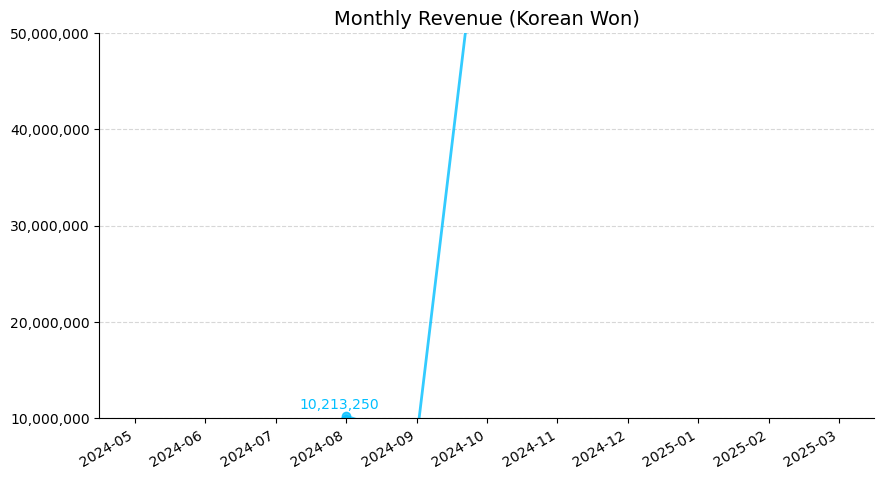

In [44]:
sales_graph()

In [46]:
sales_df.groupby(pd.Grouper(key='order_date', freq='M'))['sales'].sum().values

array([   8505650,    7594380,    4447730,    5196310,   10213250,
          7726750,   68739050,  692804440,  808549470, 1545815710,
        870596130, 1075110760,   59264270])